<h1><center>Case Study - Scotia</center></h1>

# Models

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set(rc={'figure.figsize':(16,9)})
import matplotlib as mpl
import matplotlib.pyplot as plt 

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest, f_classif, chi2, VarianceThreshold, SelectFromModel, RFE
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, mean_squared_error, f1_score, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.utils import check_array

import operator
#import prince
import shap
from scipy import stats
from scipy.stats import pearsonr, spearmanr,  chisquare

from yellowbrick.regressor import ResidualsPlot
#from yellowbrick.features import RadViz

mpl.rcParams['patch.force_edgecolor'] = True
%matplotlib inline

In [84]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_percentage_error(y_true, y_pred): 
    return np.mean(percentage_error(np.asarray(y_true), np.asarray(y_pred))) * 100

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('MPE: ', round(mean_percentage_error(y_true, y_pred),4))
    print('MAPE: ', round(mean_absolute_percentage_error(y_true, y_pred),4))
    
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [85]:
# loading df_cleaned and resetting Dtypes
df = pd.read_csv("df_cleaned.csv")
pd.set_option('display.max_columns', None)

In [86]:
df = df.drop(['CLIENTNUM'], axis=1)

|Field     |Description|
|:-------------|-----  |
|Attrition_Flag         |Flag to indicate customer attrition    |
|Customer_Age     |Customer Age    |
|Gender    |Gender     |
|Dependent_count     |Number of customer dependants     |
|Education_Level    |Education level     |
|Marital_Status     |Marital Status     |
|Income_Category     |Customer Income Category     |
|Card_Category  |Type of credit Card     |
|Months_on_book    |Time (months) with the bank     |
|Total_Relationship_Count    |Number of accounts/products the customers has with the bank     |
|Months_Inactive_12_mon  |Months of inactivity in the last 12 months     |
|Contacts_Count_12_mon  |Marketing Campaigns where the customer was reached out     |
|Credit_Limit  |Limit of Credit on the Credit card     |
|Avg_Total_Revolving_Bal  |The balance that carries over from one month to the next on the credit card     |
|Avg_Utilization_Ratio  |It's how much the customers owe divided by their credit limit     |
|Total_Trans_Amt  |Total Amount of transactions     |
|Total_Amt_Chng_Q4_Q1  |Quarter over Quarter change in the amounts of charges in the credit card     |
|Increased_Amt_Chng_Q4_Q1 |Boolean - 1 if positive / growth|
|Total_Trans_Ct  |Number of transactions     |
|Total_Ct_Chng_Q4_Q1  |Quarter over Quarter transactions count variation     |
|Increased_Ct_Chng_Q4_Q1 |Boolean - 1 if positive / growth|
|Purchase_Weight |Amount of transactions divided by Number of transactions|

Although exploratory analysis provides some interesting indicators, we can raise the bar in our analysis with machine learning models to see which features help predict the variable that matters in our case: **Attrition_Flag**.

In other words, how can we determine whether a customer is about to leave next month, to optimize the work of customer relationship managers (and offer reduced prices, if that's the case) without unnecessarily inconveniencing others?

Next, I will use two forecasting techniques: **Logistic Regression** and **Random Forest**.

Logistic Regression is useful for being able to work with continuous and discrete data. However, unlike Linear Regression, it is not easy to compare performance of models with many vs. few independent variables (there is no concept of residuals, so it is not possible to use the least squares (cost function) to calculate the R²) - For this, we test whether the effect of the independent variable in predicting the dependent is significantly different from 0 ( using Wald's Test, or Z test - I didn't use Chi-square). If not (=0), it means the variable is not helping. In other words, we use the concept of 'maximum likelihood' (we calculate the observation probability of all points on the X axis to be y=0 and y=1 (Sigmoid function converts the input into a range 0-1), and we multiply all the probabilities/likelihood together; then we move the "S" line several times and calculate the same thing until we find the curve with 'maximum likelihood'). To do this, we calculate the probability of leaving the bank by the total number of people who left the bank divided by the total number of customers. Then we multiply this probability by the total number of customers who have a specific independent variable. This will be the expected number of clients that have the independent variable AND have left the bank. And the rest is the expected number of clients that have the independent variable AND will not leave the bank. Then we do the same (probability of leaving the bank (already calculated) x total number of clients who DO NOT have this same independent variable (and subtraction).

First of all, we need to turn categorical variables into dummy variables - binary "switches" that turn the parameters in the equation on or off.

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  int64  
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  int64  
 13  Avg_Total_Revolving_Bal   10127 non-null  int64  
 14  Avg_Ut

##### Creating dummy variables

In [88]:
df_dummy = df

cat_features = pd.get_dummies(df_dummy[['Gender','Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']], drop_first=True) # create a code for each product category
cat_features = cat_features.astype(int)

df_dummy = pd.concat([df_dummy, cat_features], axis = 1) 
df_dummy = df_dummy.drop(['Gender','Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category'], axis=1)
df_dummy = df_dummy.reset_index(drop=True)

In [89]:
df_dummy.head()

Attrition_Flag  Customer_Age  Dependent_count  Months_on_book  \
0               0            45                3              39   
1               0            49                5              44   
2               0            51                3              36   
3               0            40                4              34   
4               0            40                3              21   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         3                       4                      1   
4                         5                       1                      0   

   Credit_Limit  Avg_Total_Revolving_Bal  Avg_Utilization_Ratio  \
0         12691                      777                  0.061   
1          8256                      864                  0.105   
2          3418                        0                  0.000   
3          3313                     2517                  0.760   
4          4716                        0                  0.000   

   Total_Trans_Amt  Total_Amt_Chng_Q4_Q1  Increased_Amt_Chng_Q4_Q1  \
0             1144                 1.335                         1   
1             1291                 1.541                         1   
2             1887                 2.594                         1   
3             1171                 1.405                         1   
4              816                 2.175                         1   

   Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Increased_Ct_Chng_Q4_Q1  \
0              42                1.625                        1   
1              33                3.714                        1   
2              20                2.333                        1   
3              20                2.333                        1   
4              28                2.500                        1   

   Purchase_Weight  Gender_M  Education_Level_Doctorate  \
0           27.238         1                          0   
1           39.121         0                          0   
2           94.350         1                          0   
3           58.550         0                          0   
4           29.143         1                          0   

   Education_Level_Graduate  Education_Level_High School  \
0                         0                            1   
1                         1                            0   
2                         1                            0   
3                         0                            1   
4                         0                            0   

   Education_Level_Post-Graduate  Education_Level_Uneducated  \
0                              0                           0   
1                              0                           0   
2                              0                           0   
3                              0                           0   
4                              0                           1   

   Education_Level_Unknown  Marital_Status_Married  Marital_Status_Single  \
0                        0                       1                      0   
1                        0                       0                      1   
2                        0                       1                      0   
3                        0                       0                      0   
4                        0                       1                      0   

   Marital_Status_Unknown  Income_Category_$40K - $60K  \
0                       0                            0   
1                       0                            0   
2                       0                            0   
3                       1                            0   
4                       0                   

In [90]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Attrition_Flag                  10127 non-null  int64  
 1   Customer_Age                    10127 non-null  int64  
 2   Dependent_count                 10127 non-null  int64  
 3   Months_on_book                  10127 non-null  int64  
 4   Total_Relationship_Count        10127 non-null  int64  
 5   Months_Inactive_12_mon          10127 non-null  int64  
 6   Contacts_Count_12_mon           10127 non-null  int64  
 7   Credit_Limit                    10127 non-null  int64  
 8   Avg_Total_Revolving_Bal         10127 non-null  int64  
 9   Avg_Utilization_Ratio           10127 non-null  float64
 10  Total_Trans_Amt                 10127 non-null  int64  
 11  Total_Amt_Chng_Q4_Q1            10127 non-null  float64
 12  Increased_Amt_Chng_Q4_Q1        

We also need to separate test data from training data so as not to have a complex model with a very good fit with the data, as it may not be generalist enough to work with new data (overfitting)

## Split 

In [91]:
X = df_dummy.drop('Attrition_Flag', axis=1)
y = df_dummy['Attrition_Flag'].copy()

As we saw in the exploratory analysis, classes are unbalanced (84/16).

So we use StratifiedShuffleSplit

In [92]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # a proporção de treino:teste ficou de 80:20

In [93]:
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.reindex(train_index), X.reindex(test_index)
    y_train, y_test = y.reindex(train_index), y.reindex(test_index)

In [94]:
# checking the distribution of datasets after SMOTE

print("Size of the oversampled data is ", len(X_train))
print("Number of clients who left the bank is ", len(y_train[y_train == 1]))
print("Number of customers who continued with the bank is", len(y_train[y_train == 0]))
print("Proportion of customers who left in the oversampled data is of ", len(y_train[y_train == 1]) / len(X_train))
print("Proportion of customers who continued in the oversampled data is ", len(y_train[y_train == 0]) / len(X_train))

Size of the oversampled data is  8101
Number of clients who left the bank is  1302
Number of customers who continued with the bank is 6799
Proportion of customers who left in the oversampled data is of  0.1607208986544871
Proportion of customers who continued in the oversampled data is  0.8392791013455129


We now have balanced data.

## Random Forest regression

In [95]:
model = RandomForestRegressor(n_estimators=20, random_state=0)
rfr = model.fit(X_train, y_train) 

predictions_rfr = rfr.predict(X_test)

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, predictions_rfr))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, predictions_rfr))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predictions_rfr)))
mape = mean_absolute_percentage_error(y_test, predictions_rfr)
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Absolute Error (MAE): 0.06934846989141165
Mean Squared Error (MSE): 0.03331441263573544
Root Mean Squared Error (RMSE): 0.18252236201554986
Mean Absolute Percentage Error (MAPE): 24.514473384463514


In [96]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [97]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [98]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 200, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits



3 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\tulio\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tulio\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 474, in fit
    trees = Parallel(
  File "C:\Users\tulio\anaconda3\lib\site-packages\joblib\parallel.py", line 1088, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\tulio\anaconda3\lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\tulio\ana

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [99]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [100]:
model = rf_random.best_estimator_

#model = RandomForestRegressor(n_estimators=1200,
 #min_samples_split=10,
 #min_samples_leaf=4,
 #max_features='sqrt',
 #max_depth=10,
 #bootstrap=True)

rfr_feat = model.fit(X_train, y_train) 

predictions_rfr = rfr_feat.predict(X_test)

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, predictions_rfr))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, predictions_rfr))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predictions_rfr)))
mape = mean_absolute_percentage_error(y_test, predictions_rfr)
print('Mean Absolute Percentage Error (MAPE):', mape)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


Mean Absolute Error (MAE): 0.06782647017345932
Mean Squared Error (MSE): 0.0309196151560328
Root Mean Squared Error (RMSE): 0.1758397428229261
Mean Absolute Percentage Error (MAPE): 23.7884029593309


Mean Absolute Error (MAE): 0.06934846989141165
Mean Squared Error (MSE): 0.03331441263573544
Root Mean Squared Error (RMSE): 0.18252236201554986
Mean Absolute Percentage Error (MAPE): 24.514473384463514

In [101]:
some_data = X_train.iloc[:10]
some_label = y_train.iloc[:10]

print('Predicted: {} \n Labels: {}'.format(list(rfr.predict(some_data)), list(some_label.values)))

Predicted: [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0] 
 Labels: [0, 1, 0, 0, 0, 1, 0, 0, 0, 0]


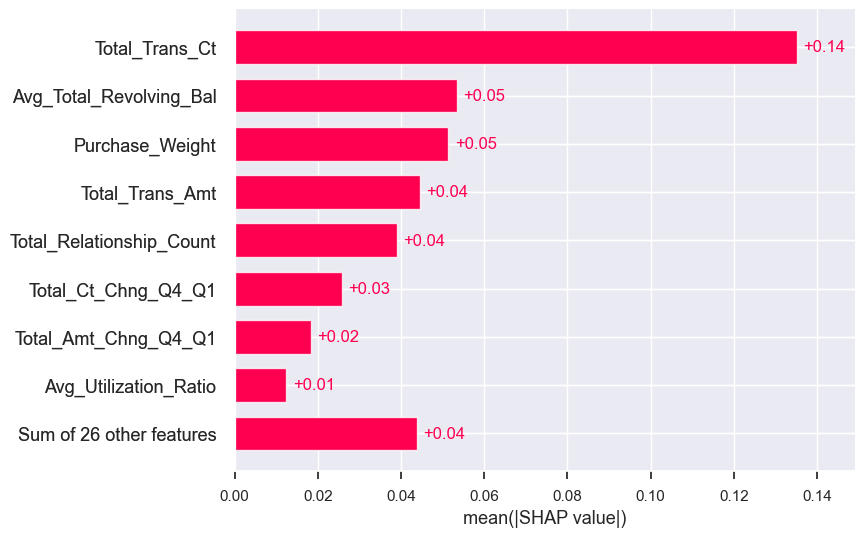

In [104]:
explainer = shap.Explainer(rfr)
shap_values = explainer(X_test)

shap.plots.bar(shap_values, max_display=9) # default is max_display=12

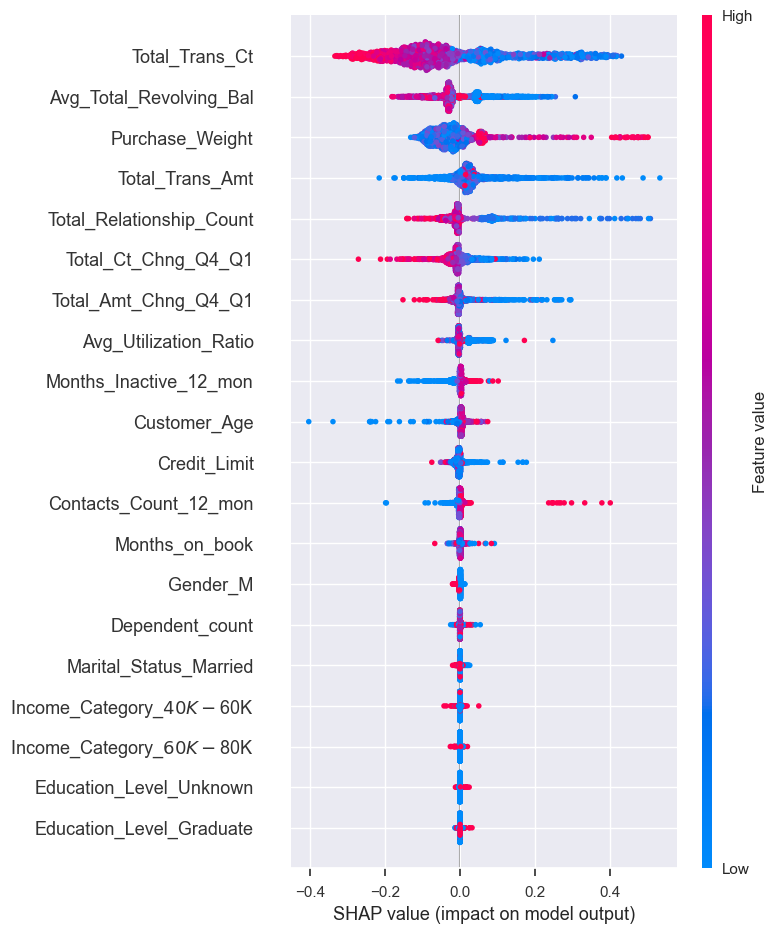

In [34]:
shap_values = shap.TreeExplainer(rfr).shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [48]:
choosen_instance = X_train.iloc[11]

shap_values_instance = explainer.shap_values(choosen_instance)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_instance, choosen_instance, plot_cmap=["#5B5BFF","#FF0000"])

In [50]:
choosen_instance = X_train.iloc[13]

shap_values_instance = explainer.shap_values(choosen_instance)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_instance, choosen_instance, plot_cmap=["#5B5BFF","#FF0000"])

In [59]:
choosen_instance = X_train.iloc[1620]

shap_values_instance = explainer.shap_values(choosen_instance)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_instance, choosen_instance, plot_cmap=["#5B5BFF","#FF0000"])

In [52]:
choosen_instance = X_train.iloc[7]

shap_values_instance = explainer.shap_values(choosen_instance)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_instance, choosen_instance, plot_cmap=["#5B5BFF","#FF0000"])

In [35]:
choosen_instance = X_train.iloc[19]

shap_values_instance = explainer.shap_values(choosen_instance)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_instance, choosen_instance, plot_cmap=["#5B5BFF","#FF0000"])

The expected value is  [0.16037526]


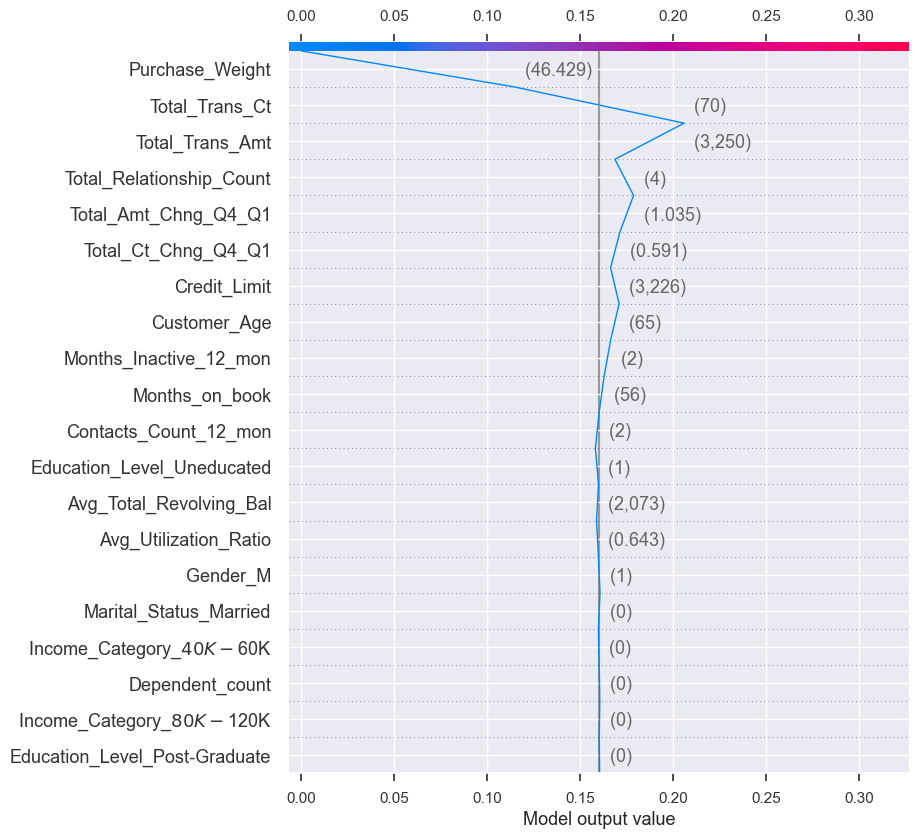

In [60]:
expected_value = explainer.expected_value
shap_values_decision = explainer.shap_values(X_test)
expected_value = explainer.expected_value

print("The expected value is ", expected_value)
shap.decision_plot(expected_value, shap_values_decision[11], X_test)

Total_Trans_Ct
Avg_Total_Revolving_Bal
Purchase_Weight
Total_Trans_Amt
Total_Relationship_Count
Total_Ct_Chng_Q4_Q1
Total_Amt_Chng_Q4_Q1
Avg_Utilization_Ratio

In [62]:
shap_values_dependence = explainer.shap_values(X_test)

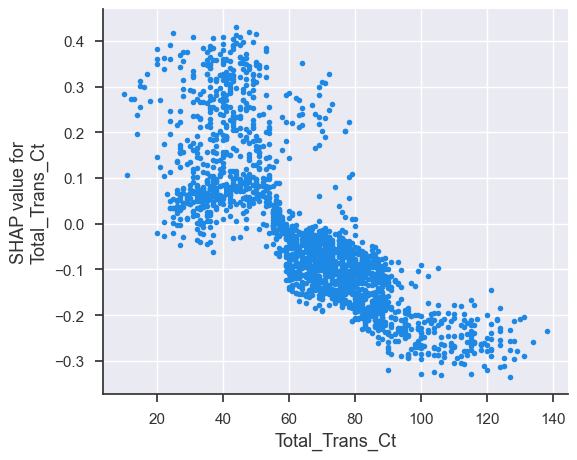

In [63]:
shap.dependence_plot("Total_Trans_Ct", shap_values_dependence, X_test, interaction_index=None)

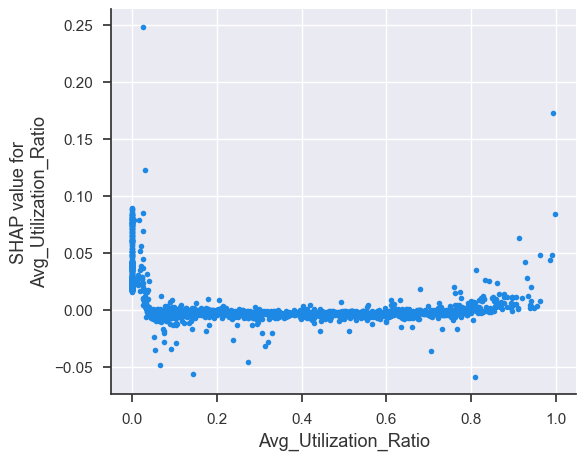

In [105]:
shap.dependence_plot("Avg_Utilization_Ratio", shap_values_dependence, X_test, interaction_index=None)

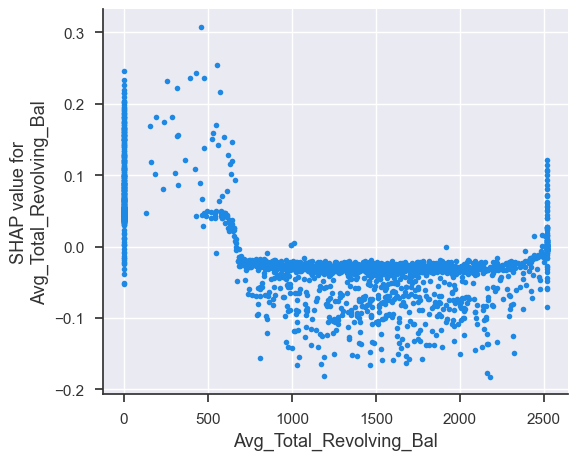

In [64]:
shap.dependence_plot("Avg_Total_Revolving_Bal", shap_values_dependence, X_test, interaction_index=None)

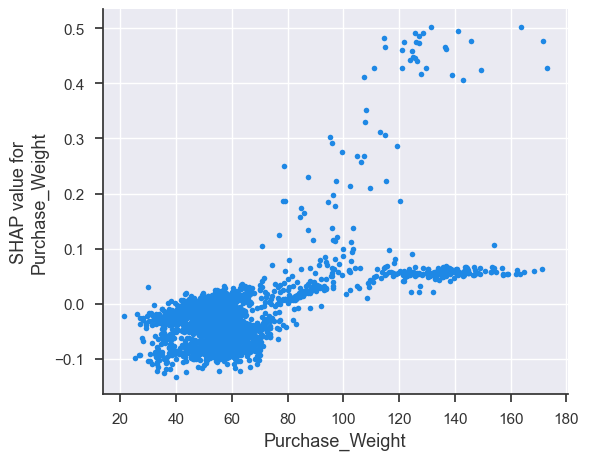

In [65]:
shap.dependence_plot("Purchase_Weight", shap_values_dependence, X_test, interaction_index=None)

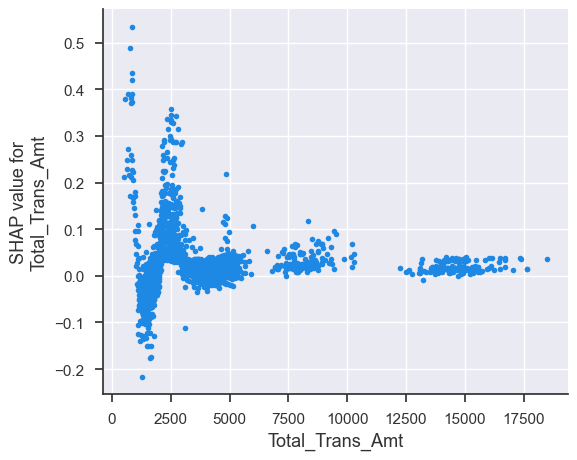

In [66]:
shap.dependence_plot("Total_Trans_Amt", shap_values_dependence, X_test, interaction_index=None)

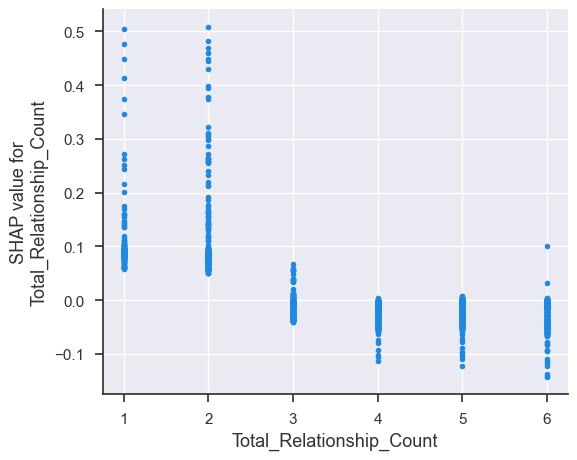

In [67]:
shap.dependence_plot("Total_Relationship_Count", shap_values_dependence, X_test, interaction_index=None)

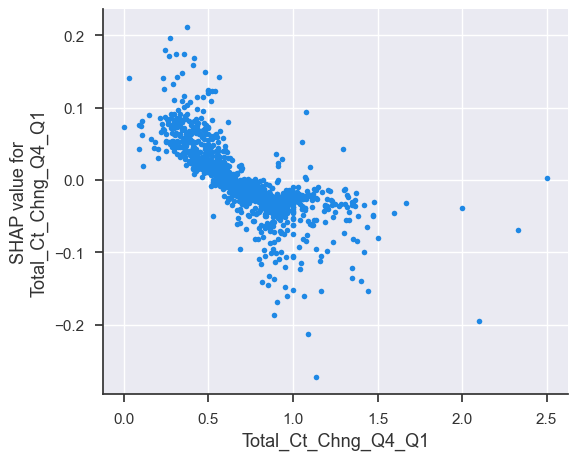

In [71]:
shap.dependence_plot("Total_Ct_Chng_Q4_Q1", shap_values_dependence, X_test, interaction_index=None)

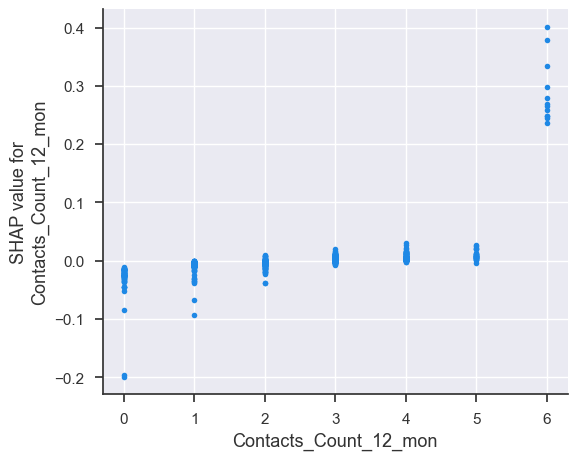

In [81]:
shap.dependence_plot("Contacts_Count_12_mon", shap_values_dependence, X_test, interaction_index=None)

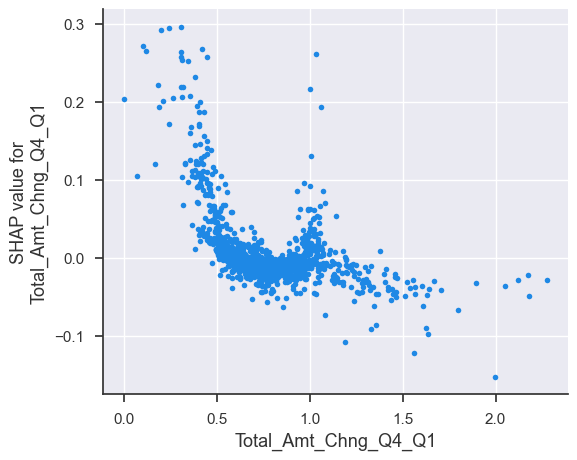

In [72]:
shap.dependence_plot("Total_Amt_Chng_Q4_Q1", shap_values_dependence, X_test, interaction_index=None)

In [ ]:
Total_Trans_Ct
Avg_Total_Revolving_Bal
Purchase_Weight
Total_Trans_Amt
Total_Relationship_Count
Total_Ct_Chng_Q4_Q1
Total_Amt_Chng_Q4_Q1

In [73]:
shap_values = shap.TreeExplainer(rfr).shap_values(X_test)

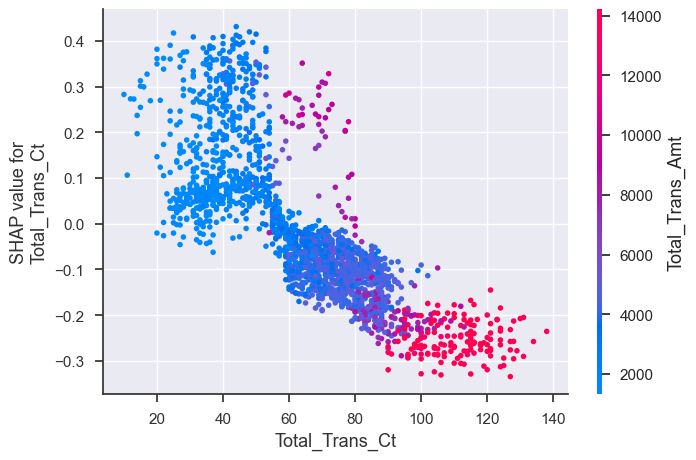

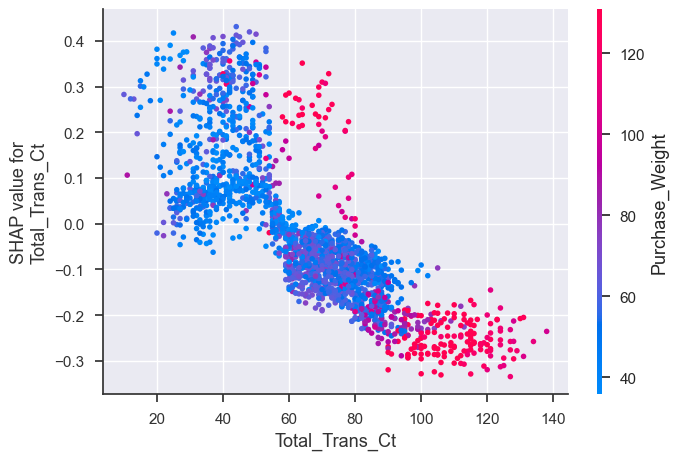

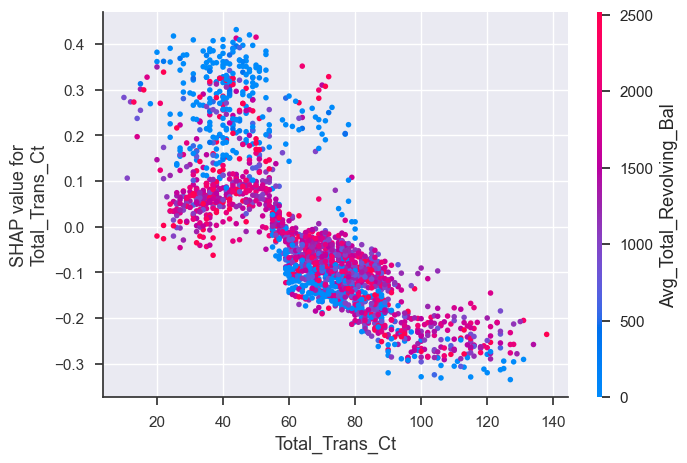

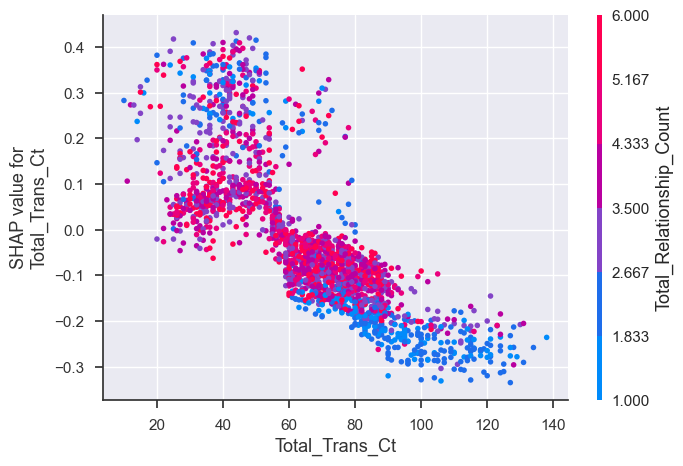

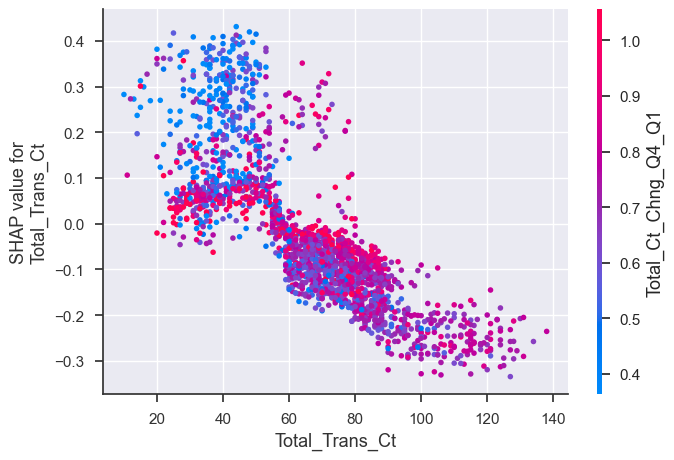

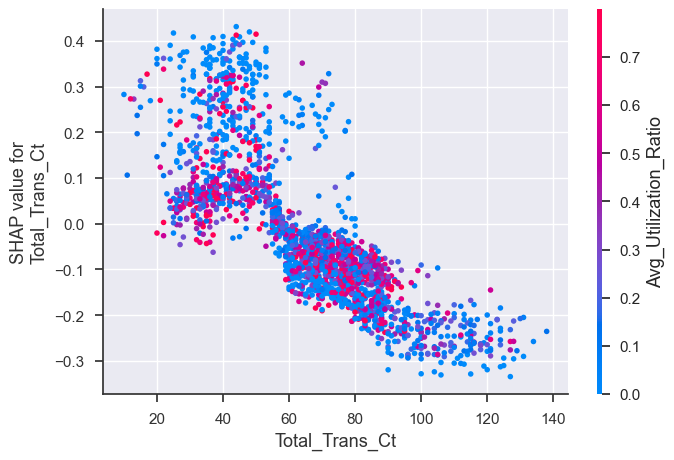

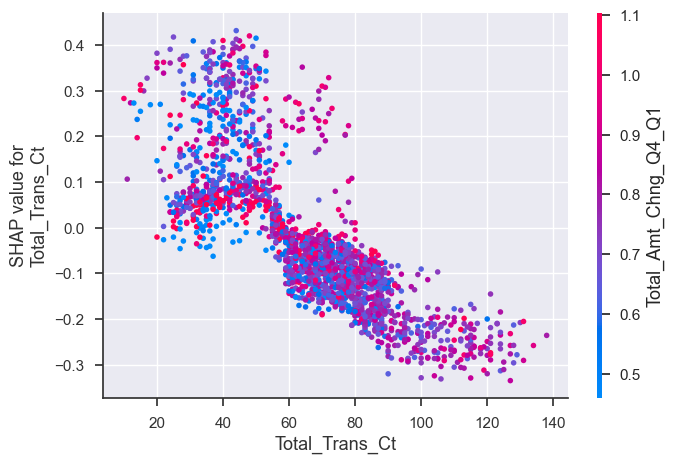

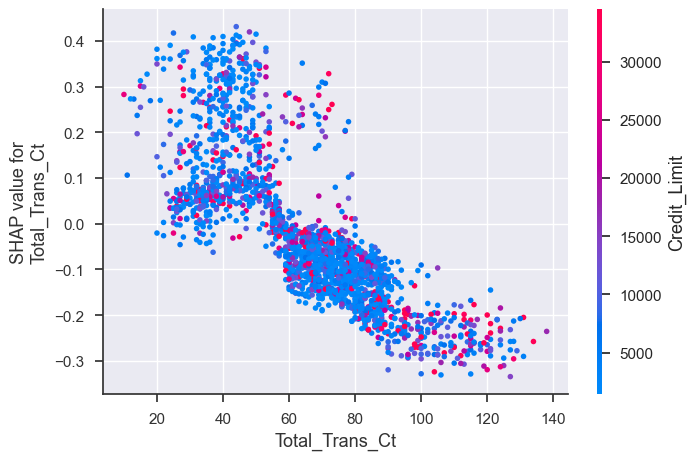

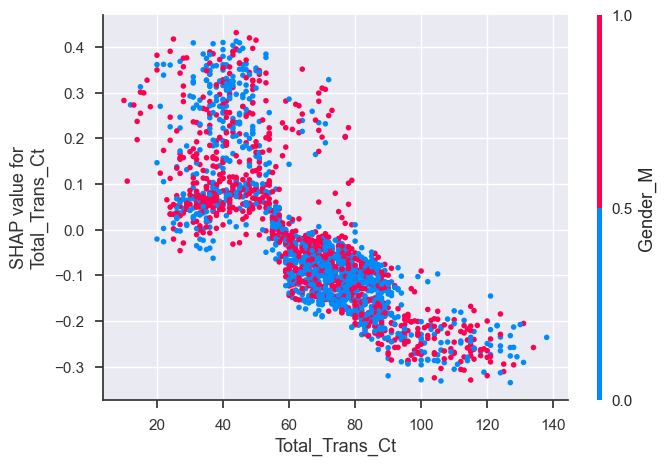

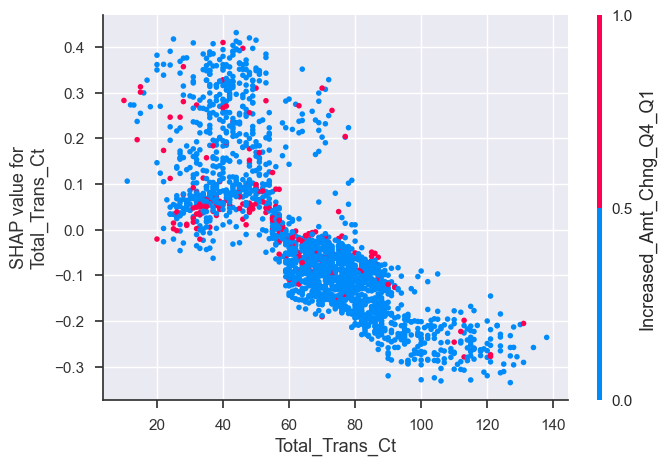

In [74]:
feat = "Total_Trans_Ct"

inds = shap.approximate_interactions(feat, shap_values, X_test)
for i in range(10):
    shap.dependence_plot(feat, shap_values, X_test, interaction_index=inds[i])

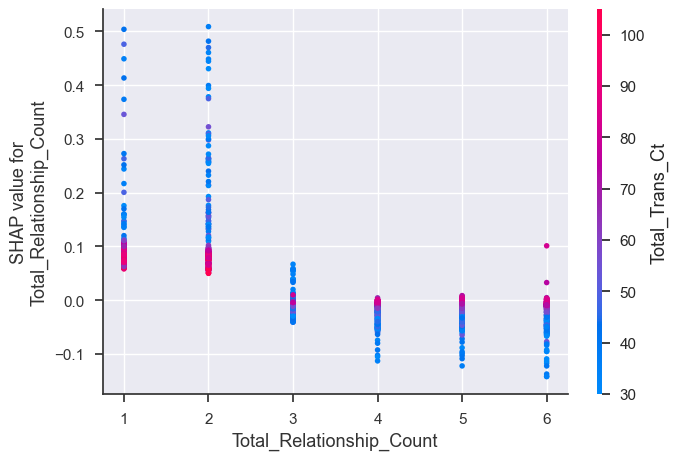

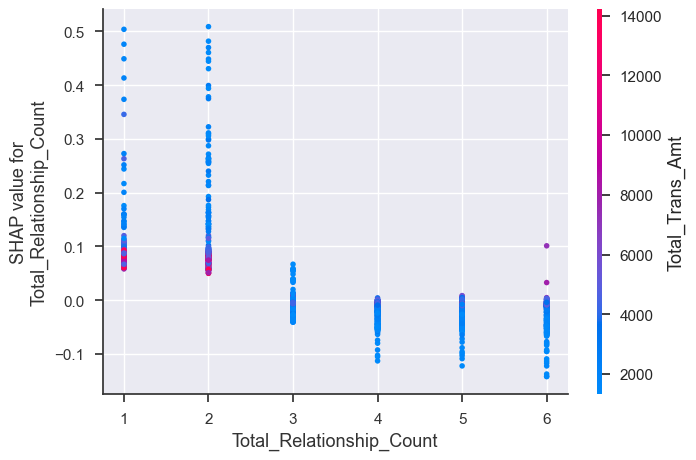

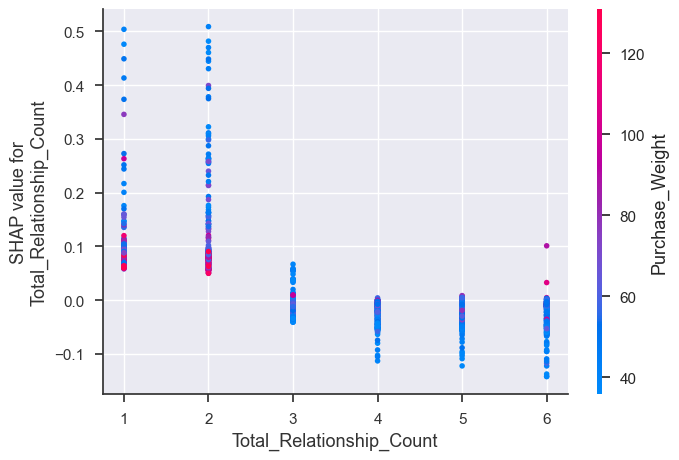

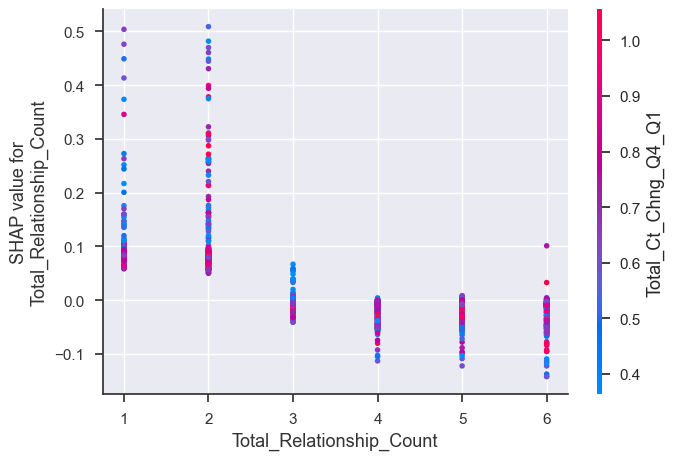

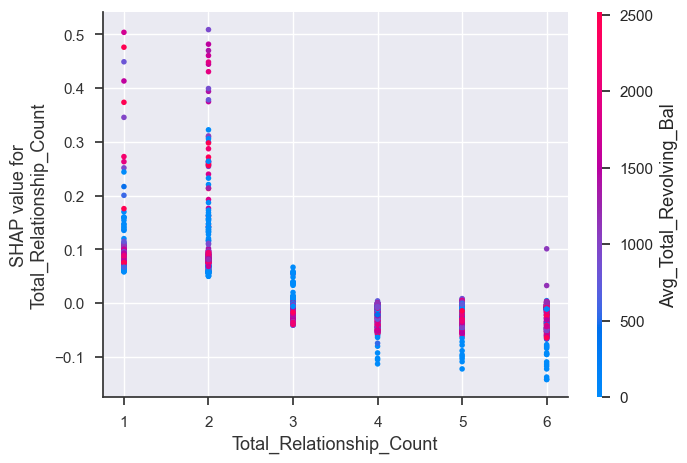

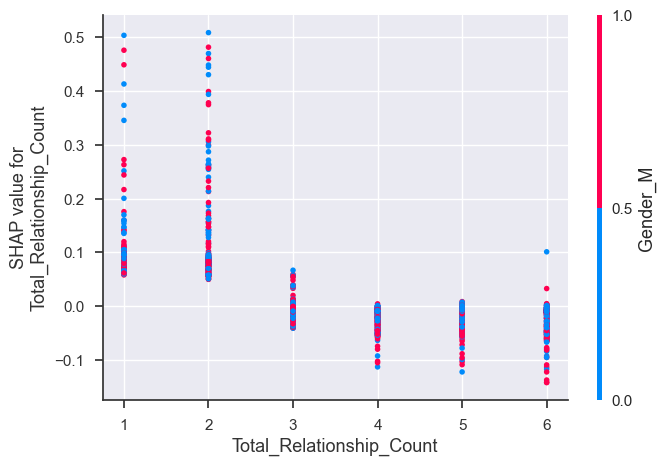

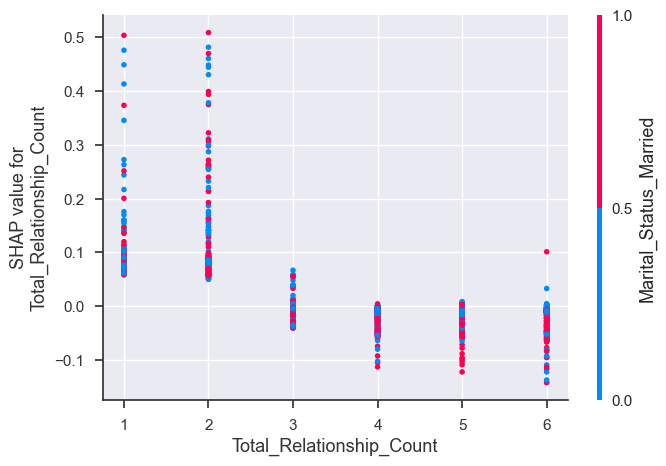

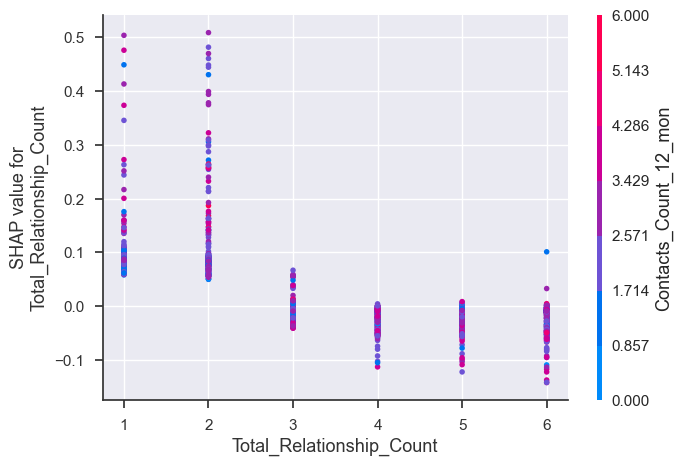

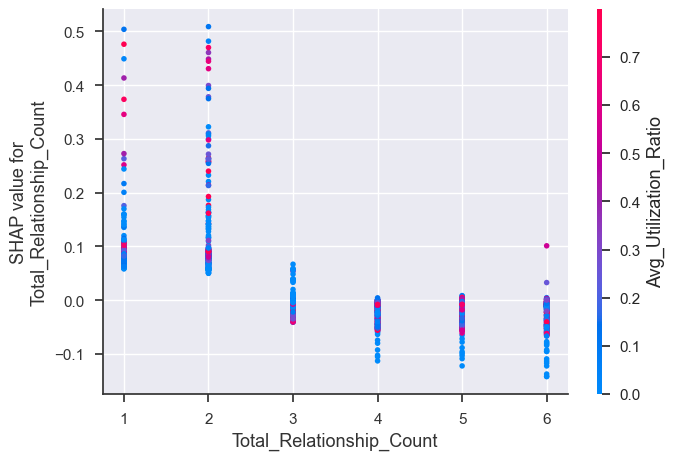

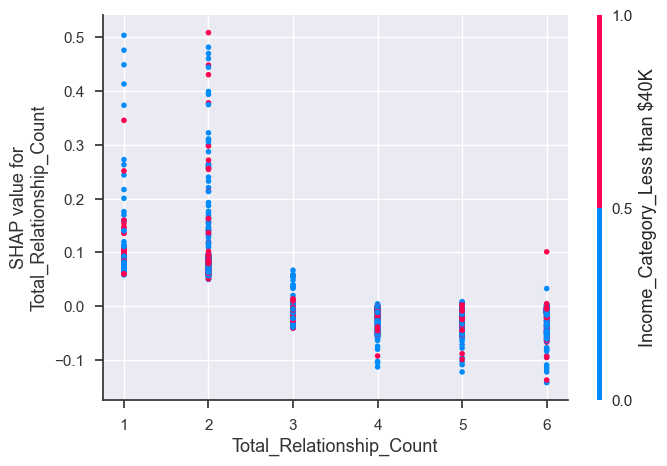

In [78]:
feat = "Total_Relationship_Count"

inds = shap.approximate_interactions(feat, shap_values, X_test)
for i in range(10):
    shap.dependence_plot(feat, shap_values, X_test, interaction_index=inds[i])

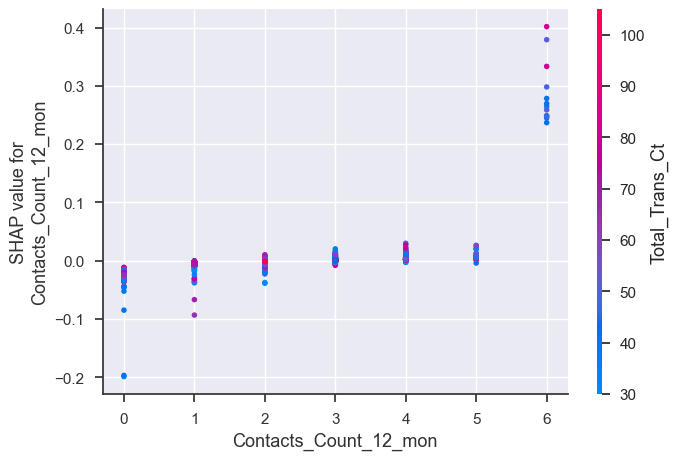

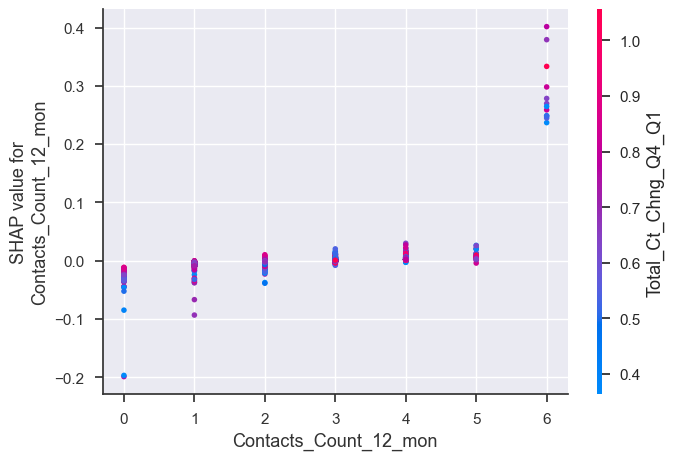

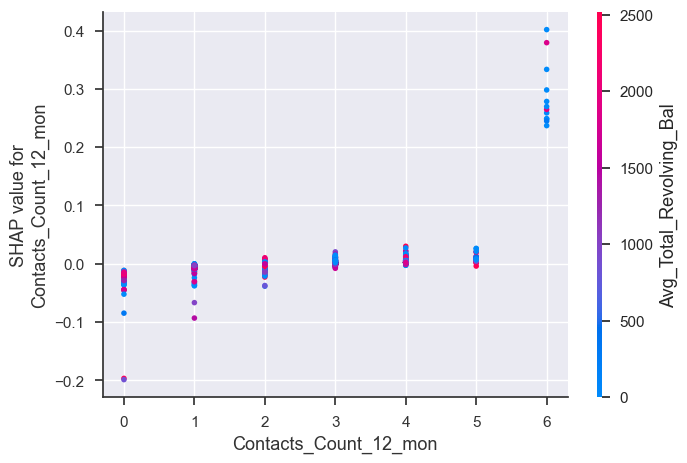

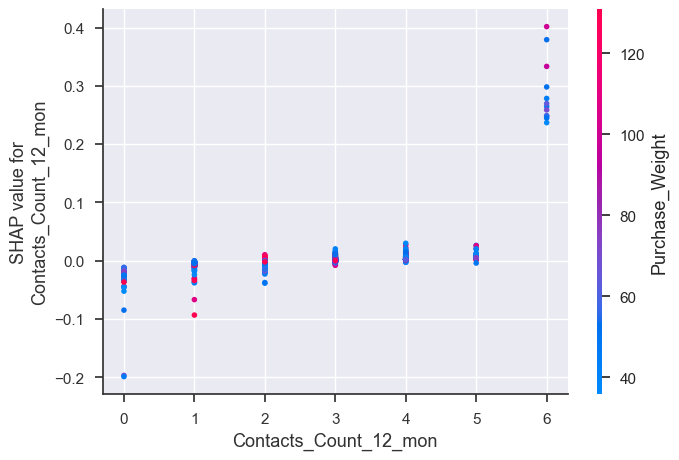

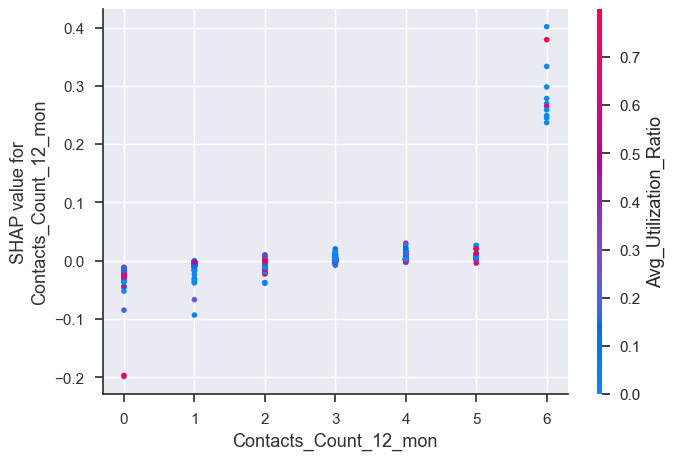

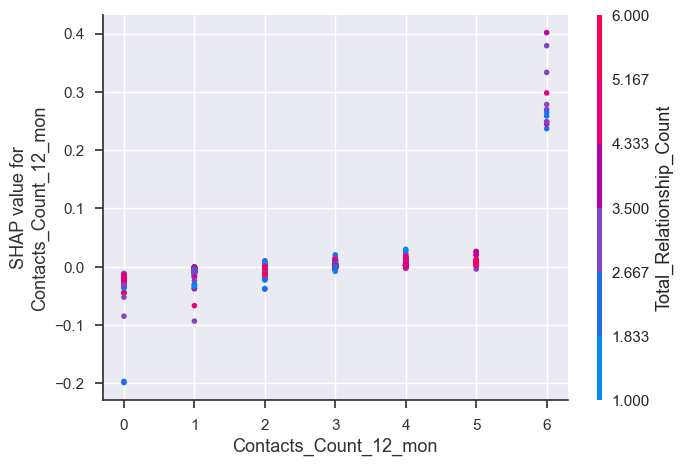

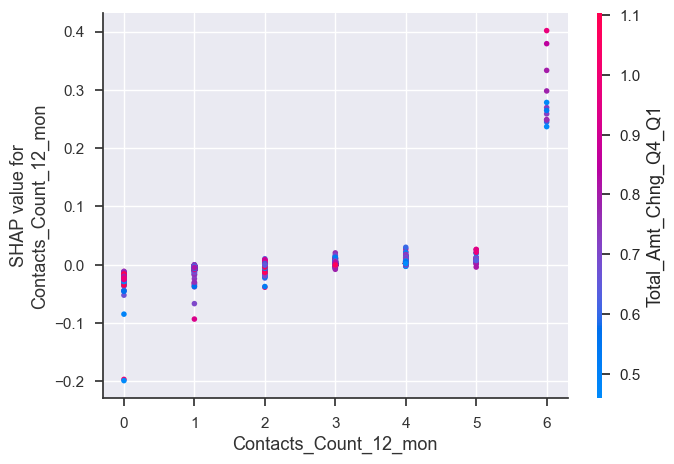

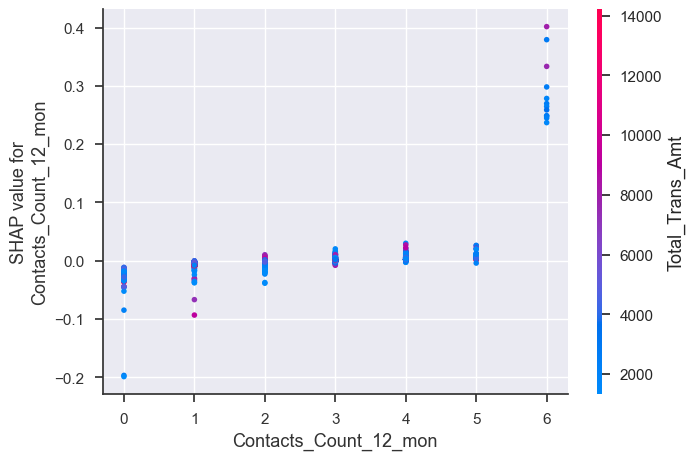

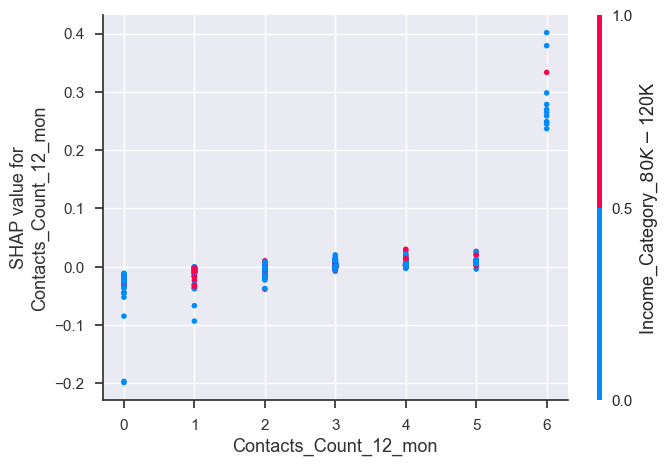

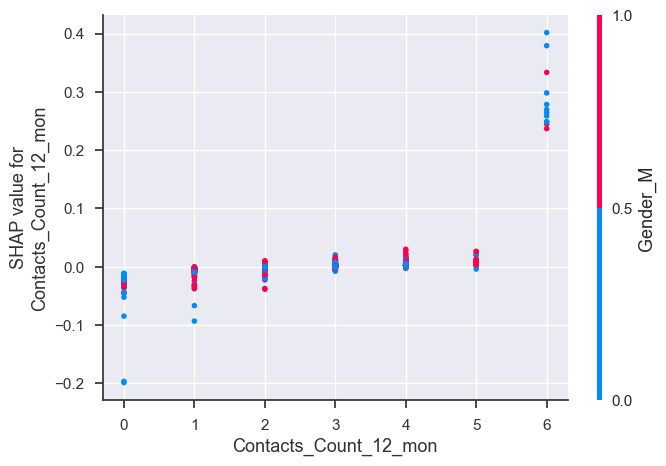

In [82]:
feat = "Contacts_Count_12_mon"

inds = shap.approximate_interactions(feat, shap_values, X_test)
for i in range(10):
    shap.dependence_plot(feat, shap_values, X_test, interaction_index=inds[i])